In [2]:
import itertools
import sys,os
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.2, rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [5]:
import mdtraj as md

## Counting contacts

In [ ]:
contact_map = {}
time = {}
soup = 'soup'
#soup = 'soupF'
contact_map = {}
ib = 50
for ions in ['phys', 'neutral']: 
    time[ions] = {}
    contact_map[ions] = {}
    for lmbd in [0, 1]:
        contact_map[ions][lmbd] = []
        xtc = "../data/GGKGG_%s_XXXL_amber99sb-star-ildn_tip3p_%s_l%i_npt_proc.xtc"%(soup, ions, lmbd)
        gro = "../data/GGKGG_%s_XXXL_amber99sb-star-ildn_tip3p_%s_l%i_nvt.gro"%(soup, ions, lmbd)
        traj = md.load_xtc(xtc, top=gro, stride=5)

        GLY = [x.index for x in list(traj.topology.residues) \
                if (x.name=='GLY')][4:] # Exclude first 4 GLY residues
        SER = [x.index for x in list(traj.topology.residues) \
                if (x.name=='SER')] 
        TYR = [x.index for x in list(traj.topology.residues) \
                if (x.name=='TYR')]
 #       PHE = [x.index for x in list(traj.topology.residues) \
 #               if (x.name=='PHE')]
        K2R = [x.index for x in list(traj.topology.residues) \
                if (x.name=='K2R')]

        nres = np.array([len(GLY), len(SER), len(TYR), len(K2R)])

        time[ions][lmbd] = traj.time[ib:]
        print (ions, lmbd, traj.n_frames)
        contact_map[ions][lmbd].append(md.compute_contacts(traj[ib:], \
            contacts=list(itertools.product(GLY, K2R)), scheme='closest-heavy'))
        contact_map[ions][lmbd].append(md.compute_contacts(traj[ib:], \
            contacts=list(itertools.product(SER, K2R)), scheme='closest-heavy'))
        contact_map[ions][lmbd].append(md.compute_contacts(traj[ib:], \
            contacts=list(itertools.product(TYR, K2R)), scheme='closest-heavy'))
 #       contact_map[ions][lmbd].append(md.compute_contacts(traj[ib:], \
 #           contacts=list(itertools.product(PHE, K2R)), scheme='closest-heavy'))

7056 500000.0


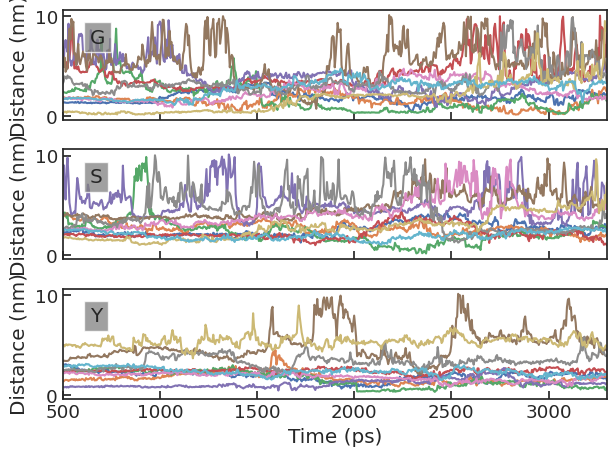

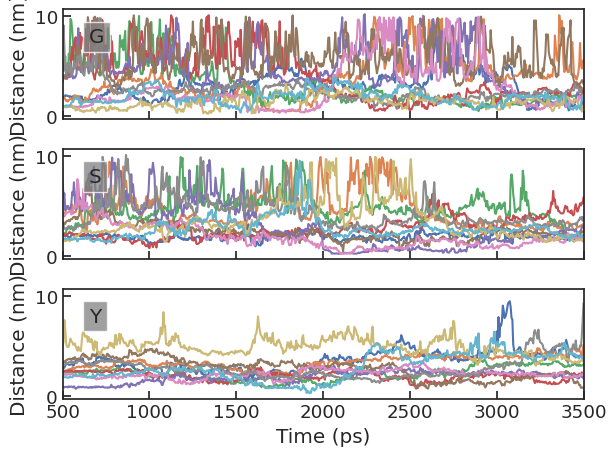

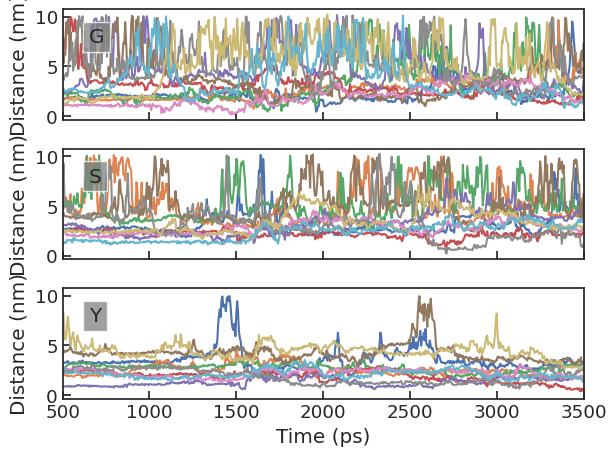

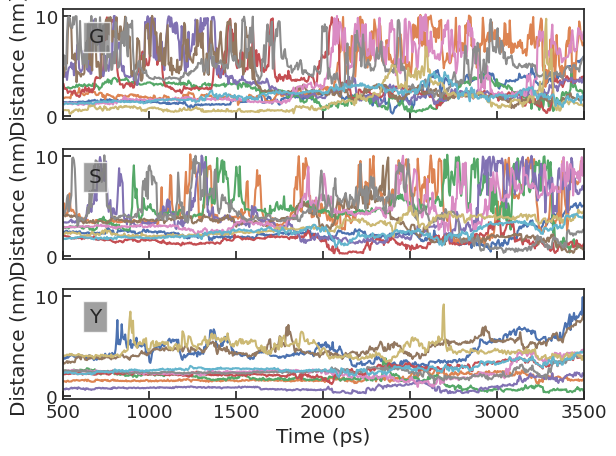

In [81]:
resname = ['G', 'S', 'Y']
#resname = ['G', 'S', 'F']
for ions in ['phys', 'neutral']: 
    for lmbd in [0, 1]:
        fig, ax = plt.subplots(3,1, sharex=True, sharey=True)
        for i in range(3):
            [ax[i].plot(time[ions][lmbd]*1e-3, contact_map[ions][lmbd][i][0][:,k]) for k in range(10)]
            ax[i].set_ylabel('Distance (nm)')
            ax[i].text(0.05, 0.7, '%s'%(resname[i]), transform=ax[i].transAxes, bbox=dict(facecolor='gray', alpha=0.75))
        ax[0].set_xlim(500, time[ions][lmbd][-1]*1e-3)
        ax[-1].set_xlabel('Time (ps)')
        plt.tight_layout()

In [6]:
def count_contacts_blocking(contact_map, n_blocks=4, rcut=0.5):
    """
    Count the number of contacts below a certain distance threshold in blocks.
    
    Parameters:
        contact_map: List of contact maps for different residue pairs.
        n_blocks: Number of blocks to divide the contact map into.
        rcut: Distance threshold for counting contacts.
    Returns:
        A list containing the number of contacts below the threshold for each residue pair in each block.
    """
    n_contacts = []
    block_size = len(contact_map) // n_blocks
    block_contacts = []
    for j in range(n_blocks):
        start = j * block_size
        end = (j + 1) * block_size if j < n_blocks - 1 else len(contact_map)
        contact_map_block = contact_map[start:end]
        block_contacts.append(count_contacts(contact_map_block, rcut))
    n_contacts.append((np.mean(block_contacts), np.std(block_contacts)))
    return n_contacts

def count_contacts(contact_map, rcut=0.5):
    """
    Count the number of contacts below a certain distance threshold.

    Parameters:
    ----------
        contact_map: np.array
            2D array with distances for different residue pairs.
        rcut: float
            Distance threshold for counting contacts.

    Returns:
    -------
        An integer representing the number of contacts below the threshold
    """
    return np.sum(contact_map < rcut) / len(contact_map)

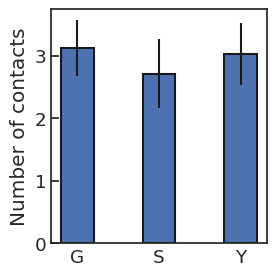

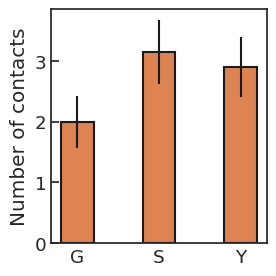

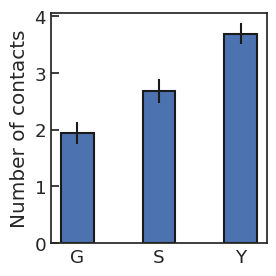

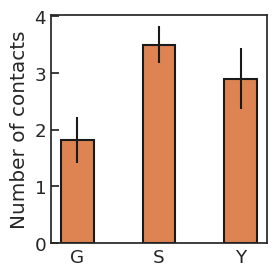

In [82]:
rcut = 0.5
for ions in ['phys', 'neutral']: 
    for lmbd in [0, 1]:
        n_cont = []
        for i in range(3):
            #n_cont.append(np.sum(contact_map[ions][lmbd][i][0] < rcut)/len(contact_map[ions][lmbd][i][0])) 
            #n_cont.append(count_contacts(contact_map[ions][lmbd][i][0], rcut))
            n_cont.append(count_contacts_blocking(contact_map[ions][lmbd][i][0], n_blocks=4, rcut=rcut))

        n_cont = np.reshape(n_cont, (3,2))
        fig, ax = plt.subplots(figsize=(3,3))
        ax.bar(range(3), n_cont[:,0] , yerr=n_cont[:,1], width=0.4, facecolor='C%i'%lmbd, edgecolor='k', linewidth=1.5) 
        ax.set_xticks(range(3))
        ax.set_xticklabels(['G', 'S', 'Y'])
        #ax.set_xticklabels(['G', 'S', 'F'])
        ax.set_ylabel('Number of contacts')
        plt.tight_layout()
        plt.savefig('figures/contacts_%s_%s_l%i.png'%(soup, ions, lmbd), dpi=300, transparent=True)

In [ ]:
ib = 100
# Find contacts for residue pairs 
# 0: Gly; 1: Ser; 2: Tyr; 3: K2R
contact_map = []
#contact_map[0] = {}; contact_map[1] = {}; contact_map[2] = {}; contact_map[3] = {}

#contact_map[0][0] = md.compute_contacts(traj[ib:], \
#                    contacts=list(itertools.combinations(GLY, 2)))    
#contact_map[1][1] = md.compute_contacts(traj[ib:], \
#                    contacts=list(itertools.combinations(SER, 2)))
#contact_map[2][2] = md.compute_contacts(traj[ib:], \
#                   contacts=list(itertools.combinations(TYR, 2)))
#contact_map[3][3] = md.compute_contacts(traj[ib:], \
#                    contacts=list(itertools.combinations(K2R, 2)))
#   
#contact_map[0][1] = md.compute_contacts(traj[ib:], \
#                    contacts=list(itertools.product(GLY, SER)))
#contact_map[0][2] = md.compute_contacts(traj[ib:], \
#                    contacts=list(itertools.product(GLY, TYR)))
#contact_map[1][2] = md.compute_contacts(traj[ib:], \
#                    contacts=list(itertools.product(SER, TYR)))

contact_map.append(md.compute_contacts(traj[ib:], \
            contacts=list(itertools.product(GLY, K2R)), scheme='closest-heavy'))
contact_map.append(md.compute_contacts(traj[ib:], \
            contacts=list(itertools.product(SER, K2R)), scheme='closest-heavy'))
contact_map.append(md.compute_contacts(traj[ib:], \
            contacts=list(itertools.product(TYR, K2R)), scheme='closest-heavy'))

## Radial distribution function

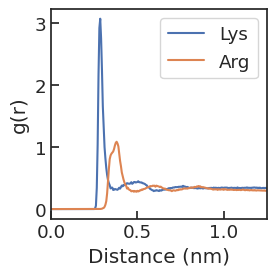

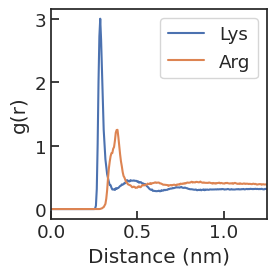

In [98]:
for ions in ["neutral", "phys"]:
    fig, ax = plt.subplots(figsize=(3,3))
    data = np.loadtxt('../analysis/GGKGG_soup_XXXL_amber99sb-star-ildn_tip3p_%s_l0_NZ_OW.xvg'%ions, comments=['@', '#'] )
    ax.plot(data[:,0], data[:,1], label='Lys')
    data = np.loadtxt('../analysis/GGKGG_soup_XXXL_amber99sb-star-ildn_tip3p_%s_l1_NZ_OW.xvg'%ions, comments=['@', '#'] )
    ax.plot(data[:,0], data[:,1], label='Arg')
    ax.set_xlabel('Distance (nm)')
    ax.set_ylabel('g(r)')
    ax.set_xlim(0,1.25)
    #ax.set_ylim(0,3.25)
    plt.legend()
    plt.tight_layout()

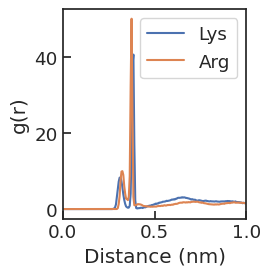

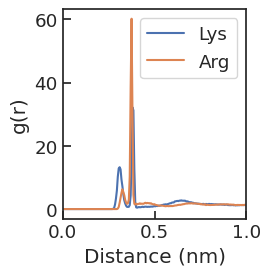

In [103]:
for ions in ["neutral", "phys"]:
    fig, ax = plt.subplots(figsize=(3,3))
    data = np.loadtxt('../analysis/GGKGG_soup_XXXL_amber99sb-star-ildn_tip3p_%s_l0_NZ_CG.xvg'%ions, comments=['@', '#'] )
    ax.plot(data[:,0], data[:,1], label='Lys')
    data = np.loadtxt('../analysis/GGKGG_soup_XXXL_amber99sb-star-ildn_tip3p_%s_l1_NZ_CG.xvg'%ions, comments=['@', '#'] )
    ax.plot(data[:,0], data[:,1], label='Arg')
    ax.set_xlabel('Distance (nm)')
    ax.set_ylabel('g(r)')
    ax.set_xlim(0,1.)
    #ax.set_ylim(0,3.25)
    plt.legend()
    plt.tight_layout()

# $\pi$-stacking 

In [6]:
def unit_normal_vector(v1, v2):
    """Calculates the unit normal vector to a plane defined by two vectors.

    Args:
        v1: The first vector defining the plane.
        v2: The second vector defining the plane.

    Returns:
        The unit normal vector to the plane.
    """

    normal = np.cross(v1, v2, axisa=1)
    norm = np.linalg.norm(normal, axis=1).reshape(np.shape(normal)[0],1)
    normal = normal / norm
    return normal

In [1]:
def get_normal(coords, id, sidechain_atoms):
    """
    Calculate the normal vector to the plane defined by three atoms

    Parameters
    ----------
        coords: 
            The coordinates of the atoms
    Returns
    -------
        normal: 
            The normal vector to the plane defined by the three atoms

    """
    try: 
        i, j, k = [x.index for x in coords.topology.residue(id).atoms if x.name in sidechain_atoms]
        displacements = md.compute_displacements(coords, [[i,j], [i,k]])
        normal = unit_normal_vector(displacements[:,0,:], displacements[:,1,:])
        return normal
    except ValueError as e:
        return None

499800.0 14036
43 46 36
499800.0 15001
43 46 36
499800.0 15001
43 46 36
499800.0 14668
43 46 36


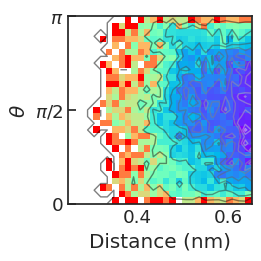

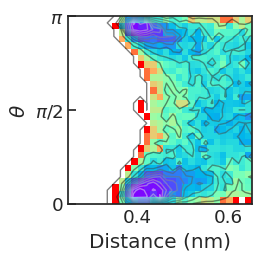

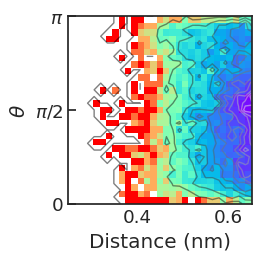

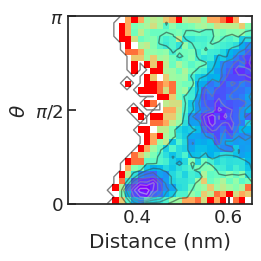

In [7]:
contact_map = {}
time = {}
soup = 'soup'

contact_map = {}
for ions in ['phys', 'neutral']: 
    time[ions] = {}
    contact_map[ions] = {}
    for lmbd in [0,1]:
        contact_map[ions][lmbd] = []
        xtc = "../data/GGKGG_%s_XXXL_amber99sb-star-ildn_tip3p_%s_l%i_npt_proc.xtc"%(soup, ions, lmbd)
        gro = "../data/GGKGG_%s_XXXL_amber99sb-star-ildn_tip3p_%s_l%i_nvt.gro"%(soup, ions, lmbd)
        traj = md.load_xtc(xtc, top=gro, stride=3)
        traj = traj[1666:]
        print (traj.time[0], traj.n_frames)
        
        TYR = [x.index for x in list(traj.topology.residues) \
                if (x.name=='TYR')]

        # Get indexes for the first three atoms in the ring
        CG = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='CG' and x.residue.name =='TYR')]
        CD1 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='CD1' and x.residue.name =='TYR')]
        CD2 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='CD2' and x.residue.name =='TYR')]       

        # Get vectors normal to the plane
        normalY = []
        for i,j,k in list(zip(CG,CD1,CD2)):
            # calculate bond vectors
            displacements = md.compute_displacements(traj, [[i,j], [i,k]])

            # calculate normal vectors
            normalY.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:]))

        K2R = [x.index for x in list(traj.topology.residues) \
                if (x.name=='K2R')]
        DNH1 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='DNH1' and x.residue.name =='K2R')][0]
        DNH2 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='DNH2' and x.residue.name =='K2R')][0]
        NZ = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='NZ' and x.residue.name =='K2R')][0]
        print (DNH1, DNH2, NZ)
        #nres = np.array([len(GLY), len(SER), len(TYR), len(K2R)])

        i,j,k = (DNH1, DNH2, NZ)
        # calculate bond vectors
        displacements = md.compute_displacements(traj, [[i,j], [i,k]])

        # calculate normal vectors
        normalR = unit_normal_vector(displacements[:,0,:], displacements[:,1,:])

        #  Get angle between vectors
        angle_between_planes = []
        for i in range(len(TYR)):
            angle_between_planes.append(np.arccos((normalY[i]*normalR).sum(1)))

        ring_dist = []
        j = K2R[0]
        j_index =  [x.index for x in traj.topology.residue(j).atoms if
                    x.name in ['DNH1', 'DNH2', 'NZ']]
        for i in TYR:
            #print (list(traj.topology.residue(i).atoms))
            i_index =  [x.index for x in traj.topology.residue(i).atoms if
                    x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']] 
            ring_dist.append(np.mean(md.compute_distances(traj, \
                    list(itertools.product(i_index, j_index))), axis=1))

        sel = np.array(ring_dist) < 0.65
        fig, ax = plt.subplots(figsize=(2.85, 2.85))
        nbins=30
        counts, xbins, ybins, image = ax.hist2d(np.array(ring_dist)[sel], np.array(angle_between_planes)[sel], \
                        bins=(np.linspace(0.25, 0.65, nbins), np.linspace(0, np.pi, nbins)), \
                            norm=LogNorm(), cmap='rainbow_r')
        ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)

        ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
        ax.set_xlabel('Distance (nm)')
        ax.set_ylabel(r'$\theta$')
        plt.tight_layout()
        plt.savefig('figures/gsy_pipi_%s_l%i.png'%(ions, lmbd), dpi=300, transparent=True)

#        stacked = []
#        for i,Y in enumerate(TYR):
#            sel = np.logical_and(ring_dist[i] < 0.45, \
#                        np.abs(angle_between_planes[i] - np.pi/2) > 1)
#            if np.any(sel):
#                atom_select = list([atom.index for atom in traj.top.residue(Y).atoms]) + \
#                        list([atom.index for atom in traj.top.residue(K2R[0]).atoms])
#                stacked.append(traj[sel].atom_slice(atom_select))
#        stacked_all = md.join(stacked)
#        stacked_all.center_coordinates()
#        stacked_all.save('gsy_pipi_%s_l%i.gro'%(ions, lmbd))

In [11]:
500000/traj.timestep

1666.6666666666667

500000.0 15001
43 46 36
500000.0 15001
43 46 36
500000.0 15001
43 46 36
500000.0 15001
43 46 36


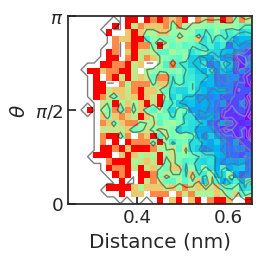

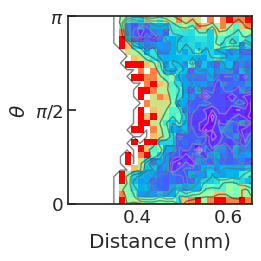

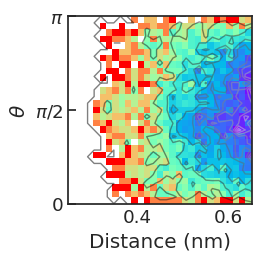

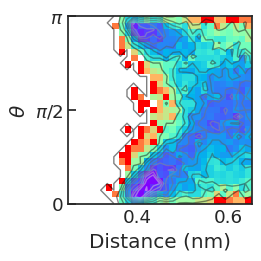

In [10]:
contact_map = {}
time = {}
soup = 'soupF'

contact_map = {}
for ions in ['phys', 'neutral']: 
    time[ions] = {}
    contact_map[ions] = {}
    for lmbd in [0,1]:
        contact_map[ions][lmbd] = []
        xtc = "../data/GGKGG_%s_XXXL_amber99sb-star-ildn_tip3p_%s_l%i_npt_proc.xtc"%(soup, ions, lmbd)
        gro = "../data/GGKGG_%s_XXXL_amber99sb-star-ildn_tip3p_%s_l%i_nvt.gro"%(soup, ions, lmbd)
        traj = md.load_xtc(xtc, top=gro, stride=1)
        traj = traj[5000:]
        print (traj.time[0], traj.n_frames)
        PHE = [x.index for x in list(traj.topology.residues) \
                if (x.name=='PHE')]

        # Get indexes for the first three atoms in the ring
        CG = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='CG' and x.residue.name =='PHE')]
        CD1 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='CD1' and x.residue.name =='PHE')]
        CD2 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='CD2' and x.residue.name =='PHE')]       

        # Get vectors normal to the plane
        normalY = []
        for i,j,k in list(zip(CG,CD1,CD2)):
            # calculate bond vectors
            displacements = md.compute_displacements(traj, [[i,j], [i,k]])

            # calculate normal vectors
            normalY.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:]))

        K2R = [x.index for x in list(traj.topology.residues) \
                if (x.name=='K2R')]
        DNH1 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='DNH1' and x.residue.name =='K2R')][0]
        DNH2 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='DNH2' and x.residue.name =='K2R')][0]
        NZ = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='NZ' and x.residue.name =='K2R')][0]
        print (DNH1, DNH2, NZ)
        #nres = np.array([len(GLY), len(SER), len(TYR), len(K2R)])

        i,j,k = (DNH1, DNH2, NZ)
        # calculate bond vectors
        displacements = md.compute_displacements(traj, [[i,j], [i,k]])

        # calculate normal vectors
        normalR = unit_normal_vector(displacements[:,0,:], displacements[:,1,:])

        #  Get angle between vectors
        angle_between_planes = []
        for i in range(len(PHE)):
            angle_between_planes.append(np.arccos((normalY[i]*normalR).sum(1)))

        ring_dist = []
        j = K2R[0]
        j_index =  [x.index for x in traj.topology.residue(j).atoms if
                    x.name in ['DNH1', 'DNH2', 'NZ']]
        for i in PHE:
            #print (list(traj.topology.residue(i).atoms))
            i_index =  [x.index for x in traj.topology.residue(i).atoms if
                    x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']] 
            ring_dist.append(np.mean(md.compute_distances(traj, \
                    list(itertools.product(i_index, j_index))), axis=1))

        sel = np.array(ring_dist) < 0.65
        fig, ax = plt.subplots(figsize=(2.85, 2.85))
        nbins=30
        counts, xbins, ybins, image = ax.hist2d(np.array(ring_dist)[sel], np.array(angle_between_planes)[sel], \
                        bins=(np.linspace(0.25, 0.65, nbins), np.linspace(0, np.pi, nbins)), \
                            norm=LogNorm(), cmap='rainbow_r')
        ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)

        ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
        ax.set_xlabel('Distance (nm)')
        ax.set_ylabel(r'$\theta$')
        plt.tight_layout()
        plt.savefig('figures/gsf_pipi_%s_l%i.png'%(ions, lmbd), dpi=300, transparent=True)

#        stacked = []
#        for i,Y in enumerate(PHE):
#            sel = np.logical_and(ring_dist[i] < 0.45, \
#                        np.abs(angle_between_planes[i] - np.pi/2) > 1)
#            if np.any(sel):
#                atom_select = list([atom.index for atom in traj.top.residue(Y).atoms]) + \
#                        list([atom.index for atom in traj.top.residue(K2R[0]).atoms])
#                stacked.append(traj[sel].atom_slice(atom_select))
#        stacked_all = md.join(stacked)
#        stacked_all.center_coordinates()
#        stacked_all.save('gsf_pipi_%s_l%i.gro'%(ions, lmbd))